### <font color="orange">ライブラリ読み込み</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [3]:
# データフレームを水平に表示する。
def show_many_dfs(*dfs, n=10):
    class HorizontalDisplay:
        def _repr_html_(self):
            template = '<div style="float: left; padding: 5px;">{}</div>'
            return  ''.join(template.format(df.head(n)._repr_html_()) for df in dfs)
    return HorizontalDisplay()

### <font color="orange">データ読み込み</font>

In [4]:
data_path = "./make_data_for_basemodel/maked_data.csv"

In [5]:
data = pd.read_csv(data_path)
data.head()

,pitch_name,game_year,game_month,game_day,home_team,LAA_score,ENEMY_score,stand,on_3b,on_2b,on_1b,inning,pitch_number,outs_when_up,balls,strikes,sz_top,sz_bot,is_first_pitch_number,release_speed,release_pos_x,release_pos_y,release_pos_z,release_spin_rate,release_extension,plate_x,plate_z,events,description,zone,type,hc_x,hc_y
0,1,2018,4,1,1,0,0,0,0,0,0,1,1,0,0,0,3.54,1.60,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2018,4,1,1,0,0,0,0,0,0,1,2,0,0,1,3.33,1.46,0,96.4,-2.16,54.05,6.20,2107.0,6.4,-0.36,2.81,19.0,2.0,4.0,0.0,0.0,0.0
2,0,2018,4,1,1,0,0,0,0,0,0,1,3,0,0,2,3.59,1.66,0,81.5,-2.36,54.42,6.03,2355.0,6.1,0.21,3.43,19.0,9.0,2.0,0.0,0.0,0.0
3,0,2018,4,1,1,0,0,0,0,0,0,1,4,0,1,2,3.33,1.46,0,83.6,-2.36,54.43,6.01,2368.0,6.1,0.24,3.67,19.0,0.0,2.0,1.0,0.0,0.0
4,1,2018,4,1,1,0,0,1,0,0,0,1,1,1,0,0,3.22,1.40,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(f"2018年 : {data[data['game_year'].isin([2018])].shape}")
print(f"2021年 : {data[data['game_year'].isin([2021])].shape}")
print(f"2022年 : {data[data['game_year'].isin([2022])].shape}")
print(f"2022年 : {data[data['game_year'].isin([2023])].shape}")
print(f"ALL : {data[data['game_year'].isin([2018, 2021, 2022, 2023])].shape}")

2018年 : (843, 33)
2021年 : (2027, 33)
2022年 : (2629, 33)
2022年 : (2094, 33)
ALL : (7593, 33)


In [7]:
data["pitch_name"].unique()

array([1, 0])

### <font color="orange">データタイプ確認</font>

In [8]:
# int, float以外のカラムがあるか確認
data.select_dtypes(exclude=["int", "float"]).columns.to_list()

[]

### <font color="orange">train_data, test_dataに分割</font>

In [9]:
def make_train_test_data(select_game_year):
    
    data = pd.read_csv(data_path)
    
    categolical_list = [
        "outs_when_up",
        "balls",
        "strikes",
        "events",
        "description",
        "zone",
        "type"
    ]
    
    data[categolical_list] = data[categolical_list].astype("category")
    
    # 対象年度の抽出
    data = data[data["game_year"].isin(select_game_year)]
    del data["game_year"]
    del data["game_month"]
    del data["game_day"]
    
    X = data.drop("pitch_name", axis=1)
    y = data["pitch_name"]
    
    # データを前半80%（train_data）と後半20%（test_data）に分割
    split_index = int(len(data) * 0.8)
    X_train = X.iloc[: split_index]
    y_train = y.iloc[: split_index]
    X_test = X.iloc[split_index : ]
    y_test = y.iloc[split_index : ]

    
    if y_train.nunique() != y_test.nunique():
        raise ValueError("train_dataとtest_dataの要素が一致していません。")
    
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = make_train_test_data(select_game_year=[2022, 2023])

# 確認
X_train.shape, X_test.shape

((3778, 29), (945, 29))

In [10]:
# カテゴリー変数の確認
X_train.select_dtypes(include="category").columns

Index(['outs_when_up', 'balls', 'strikes', 'events', 'description', 'zone',
       'type'],
      dtype='object')

### <font color="orange">モデル学習、予測</font>

In [11]:
# カスタムメトリック定義
from sklearn.metrics import f1_score, accuracy_score, log_loss

def custom_f1(y_pred, dataset):
    y_true = dataset.get_label()
    score = f1_score(y_true=y_true, y_pred=np.round(y_pred), average="macro")
    return "f1", score, True

def custom_accuracy(y_pred, dataset):
    y_true = dataset.get_label()
    auc_score = accuracy_score(y_true=y_true, y_pred=np.round(y_pred))
    return "acu", auc_score, True

def custom_multi_logloss(y_pred, dataset):
    y_true = dataset.get_label()
    multi_logloss = log_loss(y_true=y_true, y_pred=y_pred)
    return "multi_logloss", multi_logloss, False

In [12]:
import lightgbm as lgb

params = {
    "boosting" : "gbdt",
    "objective" : "binary",
    "metric" : "None",
    "first_metric_only" : True,
    "seed" : 42,
    "verbose" : -1,
    "num_threads" : 2,
    "learning_rate" : 0.01,
    "is_unbalance" : True
}

num_boost_round = 500

select_game_years = [[2018], [2021], [2022], [2023], [2018, 2021, 2022, 2023]]

models = {}
evals_results = {}

y_valid_preds = {}
y_valids = {}

y_test_preds = {}
y_tests = {}


for select_game_year in select_game_years:
    
    # data作成
    X_train, y_train, X_test, y_test = make_train_test_data(select_game_year=select_game_year)
    
    # train_dataをtrain_data（前半80%）とvalid_data（後半20%）に分割
    split_index = int(len(X_train) * 0.8)
    X_valid = X_train.iloc[split_index : ].copy()
    y_valid = y_train.iloc[split_index : ].copy()
    X_train = X_train.iloc[ : split_index].copy()
    y_train = y_train.iloc[ : split_index].copy()
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    # 誤差プロットの格納用データ
    evals_result = {}
    
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=["train", "valid"],
                      feval= [custom_f1, custom_accuracy, custom_multi_logloss],
                      callbacks=[lgb.log_evaluation(300),
                                 lgb.early_stopping(stopping_rounds=num_boost_round),
                                 lgb.record_evaluation(evals_result)]
                      )
    
    key = str(select_game_year)
    models[key] = model
    evals_results[key] = evals_result

    # 予測
    best_iteration = np.array(evals_result["valid"]["f1"]).argmax() + 1
    y_valid_pred_proba = model.predict(X_valid, num_iteration=best_iteration)
    y_valid_pred = np.round(y_valid_pred_proba)
    y_valid_preds[key] = y_valid_pred
    y_valids[key] = y_valid
      
    y_test_pred_proba = model.predict(X_test, num_iteration=best_iteration)
    y_test_pred = np.round(y_test_pred_proba)
    y_test_preds[key] = y_test_pred
    y_tests[key] = y_test
    
    print(f"best_iteration : [{best_iteration}, {model.best_iteration}]")
    print()


Training until validation scores don't improve for 500 rounds
[300]	train's f1: 0.91605	train's acu: 0.916512	train's multi_logloss: 0.374313	valid's f1: 0.695226	valid's acu: 0.696296	valid's multi_logloss: 0.582047
Did not meet early stopping. Best iteration is:
[217]	train's f1: 0.897336	train's acu: 0.897959	train's multi_logloss: 0.428766	valid's f1: 0.725685	valid's acu: 0.725926	valid's multi_logloss: 0.580974
best_iteration : [217, 217]

Training until validation scores don't improve for 500 rounds
[300]	train's f1: 0.8927	train's acu: 0.892747	train's multi_logloss: 0.378209	valid's f1: 0.55488	valid's acu: 0.584615	valid's multi_logloss: 0.699266
Did not meet early stopping. Best iteration is:
[490]	train's f1: 0.93668	train's acu: 0.936728	train's multi_logloss: 0.290893	valid's f1: 0.574224	valid's acu: 0.606154	valid's multi_logloss: 0.705297
best_iteration : [490, 490]

Training until validation scores don't improve for 500 rounds
[300]	train's f1: 0.888785	train's acu: 0

### <font color="orange"> 確認</font>

In [13]:
# カテゴリーカラムの確認
df_category = pd.DataFrame({"category_name" : X_train.select_dtypes(include="category").columns.to_list(),
                            "unique_value" : model.pandas_categorical,
                            "n_unique" : [len(n) for n in model.pandas_categorical]})
df_category

,category_name,unique_value,n_unique
0,outs_when_up,"[0, 1, 2]",3
1,balls,"[0, 1, 2, 3]",4
2,strikes,"[0, 1, 2]",3
3,events,"[9.0, 14.0, 19.0]",3
4,description,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, ...",10
5,zone,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",13
6,type,"[0.0, 1.0, 2.0]",3


In [14]:
# モデルのパラメータ確認
key_to_get = [
    "boosting",
    "objective",
    "metric",
    "first_metric_only",
    "num_iterations",
    "learning_rate",
    "num_leaves",
    "seed",
    "max_depth",
    "min_data_in_leaf",
    "bagging_fraction",
    "bagging_freq",
    "extra_trees",
    "early_stopping_round",
    "first_metric_only",
    "lambda_l1",
    "lambda_l2",
    "max_bin",
    "min_data_in_bin",
    "is_unbalance"
]

lgb_params = {key : model._get_loaded_param()[key] for key in key_to_get}
df_params = pd.DataFrame({"param_name" : lgb_params.keys(),
                          "param_value" : lgb_params.values()})

if False:
    display(df_params)

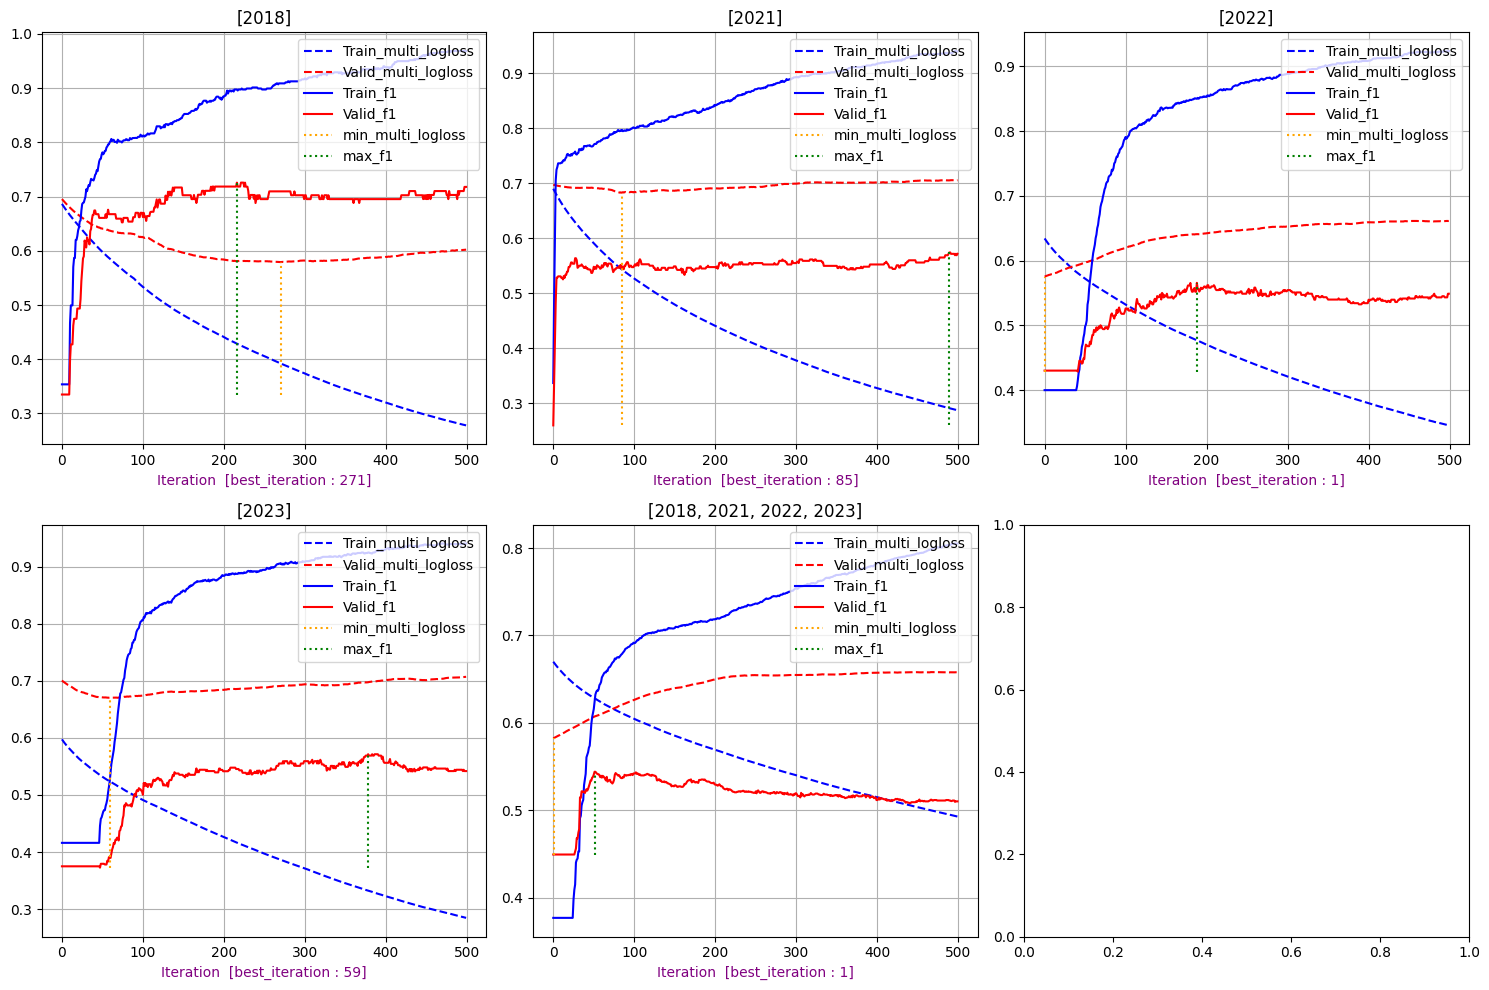

In [15]:

import matplotlib.pyplot as plt

def metrics_plot(evals_results, select_multi_logloss=True, select_f1=True, select_acu=True, x_range=500):
    
    x_range = x_range
    
    if len(evals_results) <4:
        fig, axes = plt.subplots(1, len(evals_results), figsize=(15, 5))
    else:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    i = 0
    
    for key, value in evals_results.items():
        
        if i <3:
            row = 0
            ax = axes[row, i]
        else:
            row = 1
            ax = axes[row, i-3]
            
        if select_multi_logloss:
            ax.plot(value["train"]["multi_logloss"][:x_range], label="Train_multi_logloss", linestyle="dashed", color="blue")
            ax.plot(value["valid"]["multi_logloss"][:x_range], label="Valid_multi_logloss", linestyle="dashed", color="red")

        if select_f1:
            ax.plot(value["train"]["f1"][:x_range], label="Train_f1", color="blue")
            ax.plot(value["valid"]["f1"][:x_range], label="Valid_f1", color="red")

        if select_acu:
            ax.plot(value["train"]["acu"][:x_range], label="Train_acu", linestyle="dotted", color="blue")
            ax.plot(value["valid"]["acu"][:x_range], label="Valid_acu", linestyle="dotted", color="red")
    
       
        # multi_loglosssの最小値をとるイテレーション回数を取得
        x_min_logloss = np.array(value["valid"]["multi_logloss"]).argmin() + 1
        
        # f1の最大値をとるイテレーション回数を取得
        x_max_f1 = np.array(value["valid"]["f1"]).argmax()
        y_min = np.array(value["valid"]["f1"]).min()
        y_min_multi_logloss = np.array(value["valid"]["multi_logloss"]).min()
        y_max_f1 = np.array(value["valid"]["f1"]).max()
        ax.vlines(x_min_logloss, y_min, y_min_multi_logloss, color="orange", linestyles="dotted", label="min_multi_logloss")
        ax.vlines(x_max_f1, y_min, y_max_f1, color="green", linestyles="dotted", label="max_f1")
        
        ax.set_xlabel(f"Iteration  [best_iteration : {x_min_logloss}]", color="purple")
        ax.set_title(key)
        ax.legend(loc="upper right")
        ax.grid()
        
        i += 1

    plt.tight_layout()
    plt.show()

metrics_plot(evals_results, select_multi_logloss=True, select_f1=True, select_acu=False, x_range=num_boost_round)

In [16]:
# 正解率とf1スコア
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


def calc_score(y_preds:dict, y_trues:dict) -> pd.DataFrame:
    
    df_score = pd.DataFrame()
    
    for key, value in y_preds.items():
        # 正解率
        auc_score = accuracy_score(y_pred=value, y_true=y_trues[key])
        df_score.loc[key, "auc"] = np.round(auc_score, 4)

        # f1スコア
        f1 = f1_score(y_pred=value, y_true=y_trues[key], average="macro")
        df_score.loc[key, "f1"] = np.round(f1, 4)

    df_score.rename(index={"[2018, 2021, 2022, 2023]" : "[all]"}, inplace=True)
    
    return df_score

df_valid_score = calc_score(y_preds=y_valid_preds, y_trues=y_valids)
df_test_score = calc_score(y_preds=y_test_preds, y_trues=y_tests)

show_many_dfs(df_valid_score, df_test_score)

,auc,f1
[2018],0.7259,0.7257
[2021],0.6062,0.5742
[2022],0.6366,0.5658
[2023],0.6119,0.5714
[all],0.7481,0.5440
,auc,f1
[2018],0.6450,0.6444
[2021],0.6059,0.5455
[2022],0.6141,0.4505
[2023],0.5370,0.4834


In [17]:
# 混同行列の作成
from sklearn.metrics import confusion_matrix

# pitch_nameをエンコーディング
pitch_name_encording = {
    "Other" : 0,
    "4-Seam Fastball" : 1,
}

def show_confusion_matrix(y_tests=y_tests, y_test_preds=y_test_preds):
    
    for key in y_tests.keys():
        tmp_y_test = y_tests[key]
        tmp_y_test_pred = y_test_preds[key]
        
        labels = [i for i in range(tmp_y_test.nunique())]
        cm = confusion_matrix(y_true=tmp_y_test, y_pred=tmp_y_test_pred, labels=labels)

        labels_name = list(pitch_name_encording.keys())
        columns_labels = ["pred_"+str(label) for label in labels_name]
        index_labels = ["act_"+str(label) for label in labels_name]
        cm = pd.DataFrame(cm, index=index_labels, columns=columns_labels)
        
        print(key)
        display(cm)

if True:    # 出力が多いので、見たいときだけTrueにすること。
    show_confusion_matrix(y_tests=y_tests, y_test_preds=y_test_preds)

[2018]


,pred_Other,pred_4-Seam Fastball
act_Other,58,30
act_4-Seam Fastball,30,51


[2021]


,pred_Other,pred_4-Seam Fastball
act_Other,197,89
act_4-Seam Fastball,71,49


[2022]


,pred_Other,pred_4-Seam Fastball
act_Other,305,166
act_4-Seam Fastball,37,18


[2023]


,pred_Other,pred_4-Seam Fastball
act_Other,180,72
act_4-Seam Fastball,122,45


[2018, 2021, 2022, 2023]


,pred_Other,pred_4-Seam Fastball
act_Other,823,154
act_4-Seam Fastball,440,102


In [18]:
# feature_impotanceのデータフレーム作成
def make_df_feature_importance(X_train, models):
    
    dfs = []
    
    for key, model in models.items():
        df_feature_importance = pd.DataFrame({"column_name" : X_train.columns,
                                              "F.I" : model.feature_importance("gain")
                                              })

        df_feature_importance = df_feature_importance.sort_values(by="F.I", ascending=False)
        df_feature_importance["F.I"] = df_feature_importance["F.I"].map(lambda x : int(x))
        
        dfs.append(df_feature_importance)

    # すべてのfeature_importanceを加算したデータフレームを作成する。
    sum_fi = 0
    # F.Iを加算
    for df in dfs:
        sum_fi += df["F.I"]
    # データフレーム化
    df_total_feature_importance = pd.DataFrame({"column_name" : dfs[0]["column_name"],
                                                "F.I" : sum_fi})
    # F.Iでソートする
    df_total_feature_importance.sort_values(by="F.I", ascending=False, inplace=True)
        
    return dfs, df_total_feature_importance


if True:
    years = [i for i in evals_results.keys()]
    print(years)
    
    dfs_feature_importance, df_total_feature_importance = make_df_feature_importance(X_train=X_train, models=models)
    
    display(
        show_many_dfs(dfs_feature_importance[0],
                      dfs_feature_importance[1],
                      dfs_feature_importance[2],
                      dfs_feature_importance[3],
                      dfs_feature_importance[4],
                      n=5)
    )
    print("[Total]")
    display(df_total_feature_importance.head())

['[2018]', '[2021]', '[2022]', '[2023]', '[2018, 2021, 2022, 2023]']


,column_name,F.I
12,sz_top,1823
21,plate_x,1510
17,release_pos_y,1228
15,release_speed,1123
9,outs_when_up,1058
,column_name,F.I
11,strikes,6241
13,sz_bot,4238
22,plate_z,4061
7,inning,3815


[Total]


,column_name,F.I
15,release_speed,17488
11,strikes,16112
21,plate_x,15865
16,release_pos_x,15547
22,plate_z,15117


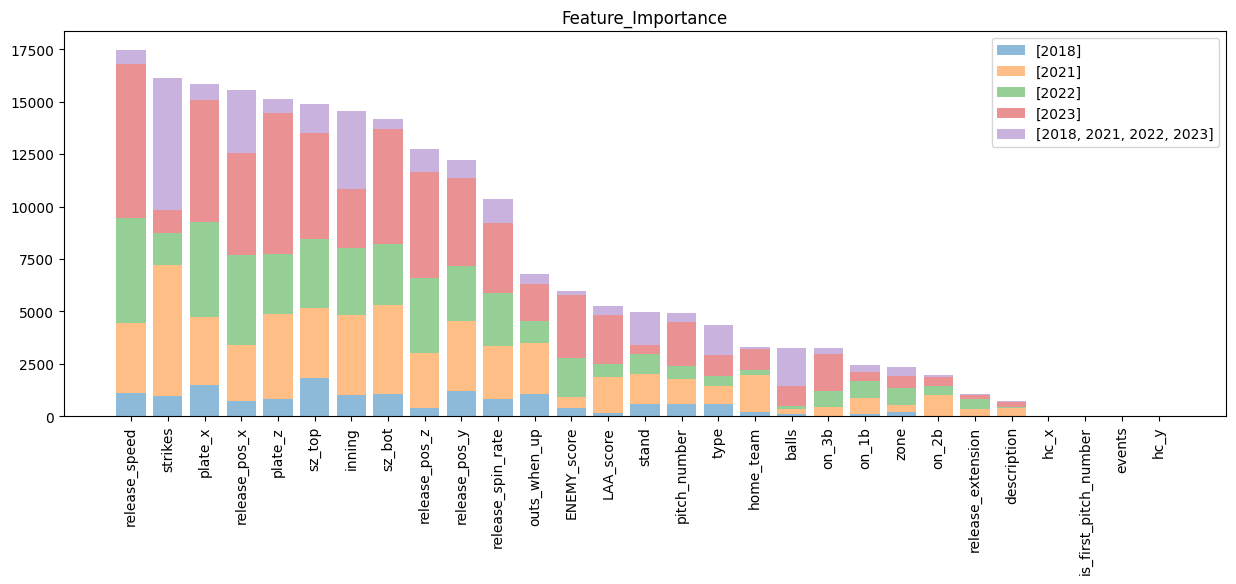

In [19]:
def plot_feature_importance():

    dfs_feature_importance, df_total_feature_importance = make_df_feature_importance(X_train=X_train, models=models)
    
    plt.figure(figsize=(15,5))

    sum_fi = 0
    years = [i for i in evals_results.keys()]

    for i in range(len(dfs_feature_importance)):

        merge_df = pd.merge(left=df_total_feature_importance["column_name"], right=dfs_feature_importance[i], on="column_name", how="left")

        label = years[i]

        plt.bar(x=df_total_feature_importance["column_name"],
                height=merge_df["F.I"],
                bottom= sum_fi,
                alpha=0.5,
                label = label)

        sum_fi += merge_df["F.I"]

    plt.title("Feature_Importance")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


plot_feature_importance()

### <font color="orange">検証データをテストデータに戻して、モデル作成</font>

In [20]:
import lightgbm as lgb

y_test_preds = {}
y_tests = {}

for select_game_year in select_game_years:
    
    # data作成
    X_train_full, y_train_full, X_test, y_test = make_train_test_data(select_game_year=select_game_year)
    
    lgb_train_full = lgb.Dataset(X_train_full, y_train_full)
    
    # num_boost_roundの設定
    if select_game_year == [2018]:
        models["[2018]"].best_iteration + 20
    elif select_game_year == [2021]:
        models["[2021]"].best_iteration + 20
    elif select_game_year == [2022]:
        models["[2022]"].best_iteration + 20
    elif select_game_year == [2023]:
        models["[2023]"].best_iteration + 20
    elif select_game_year == [2018, 2021, 2022, 2023]:
        models["[2018, 2021, 2022, 2023]"].best_iteration + 20
    
    # print(num_boost_round)
    
    # 誤差プロットの格納用データ
    evals_result = {}
    
    model = lgb.train(params=params,
                      train_set=lgb_train_full,
                      num_boost_round=num_boost_round,

                      feval=[custom_f1, custom_accuracy, custom_multi_logloss],
                      callbacks=[lgb.log_evaluation(500)]
                      )
    
    key = str(select_game_year)
    evals_results[key] = evals_result

    # 予測
    y_test_pred_proba = model.predict(X_test)
    y_test_pred = np.round(y_test_pred_proba)
    
    y_test_preds[key] = y_test_pred
    y_tests[key] = y_test

In [21]:
df_test_score = calc_score(y_preds=y_test_preds, y_trues=y_tests)
df_test_score

,auc,f1
[2018],0.6627,0.6620
[2021],0.5837,0.5169
[2022],0.6046,0.4386
[2023],0.5346,0.4960
[all],0.5655,0.5180


In [22]:
# 混同行列の出力
if False:    # 出力が多いので、見たいときだけTrueにすること。
    show_confusion_matrix(y_tests=y_tests, y_test_preds=y_test_preds)